# BINF TP3 - Algorithmes d'alignement par paire

Dans ce TP nous allons manipuler les algorithmes d'alignement par paire.

_________________________________________________________________________

Hello Professor,

Yes, the code of the few exercises showed underneath is made through chatGPT.
I was to lazy to write them and to be fair, we have a few project to do at the same time and I don't want redo a ING1.
Futhermore I would not be sure of finishing the tp elsewise because I code pretty slowly.

But all the non code question where made by hand.

And I always re-read the code to make sure I understand everything, make sure there is no weird things happening and that I understand everything.

Still, I want to point out I didn't understand how to traduce those sequences x = "𝐴𝑌678264∗". And thus those parts are wrong.

Sincerly,

David GONCALVES

_________________________________________________________________________

# Exercice 0 - Echauffement

Q1. Donnez le score de la superposition :

|       |       |
| :---: | :---: |
x       | ATGTCATGA---TAC |
y       | AT--CTAAATGTTAC |


étant donne le schéma d'évaluation :

|       | A     | T     | G     | C     |
| :---: | :---: | :---: | :---: | :---: |
| **A** | 1     | -1    | -1    | -1    |
| **T** | -1    | 1     | -1    | -1    |
| **G** | -1    | -1    | 1     | -1    |
| **C** | -1    | -1    | -1    | 1     |

et

$\gamma(g) = 0.5 |g| + 0.5$

```markdown
We have 3 gaps for x and 2 gaps for y:

y(5) = 0.5 * 5 = 2.5 (not affine, linear, so it's the same than doing them separately)

and for the association we have:

7 - 3 = 4

so the score is:

score(x, y) = 4 - 2.5 = 1.5
```

Q2. Alignez les séquences suivantes avec l'algorithme de Levenshtein :  x = ATG et y = ACTG.

```markdown

  O A T G
O 0 1 2 3
A 1 0 1 2
C 2 1 1 2
T 3 2 1 2
G 4 3 2 1

  O A T G
O 0 - - -
A | \ - -
C | | \ -
T | | \ \
G | | | \

So the we do:

GG - TT - CA - AA - 00
GTCA
Insertion of C
```

Q3.	Alignez les séquences suivantes avec l'algorithme de Needleman-Wunsch global x = TAT et y = ATGAC en considérant le schéma d'évaluation suivant

|       | A       | T       | G       | C     |
| :---: | :---:   | :---:   | :---:   | :---: |
| **A** | 1       | -0.5    | -0.5    | -0.5  |
| **T** | -0.5    | 1       | -0.5    | -0.5  |
| **G** | -0.5    | -0.5    | 1       | -0.5  |
| **C** | -0.5    | -0.5    | -0.5    | 1     |

et

$\gamma(g) = 0.5 |g|$


```markdown
  0     A     T     G     A     C
0 0     -0.5  -1    -1.5  -2    -2.5
T -0.5  -0.5  0.5   0     -0.5  -1
A -1    0.5   0     0     1     -0.5
T -1.5  0     1.5   1     0.5   0.5  

  0 A T G A C
0 0 - - - - -
T | \ \ - - -
A | \ \ - \ -
T | | \ - - \

_T_AT
ATGAC
```

Q4. Alignez les séquences suivantes avec l'algorithme de Smith-Waterman x = TTGG y = ATGAC en utilisant le schéma d'évaluation de la question précédente.


```markdown
  0     A     T     G     A     C
0 0     -0.5  -1    -1.5  -2    -2.5
T -0.5  -0.5  0.5   0     -0.5  -1
T -1    -1    0.5   0     -0.5  -1
G -1.5  -1.5  0     1.5   1     0.5
G -2    -2    -0.5  1     1     0.5

  0 A T G A C
0 0 - - - - -
T | \ \ - - -
T | \ \ \ \ \
G | \ | \ - -
G | \ | \ \ \



```

# Exercice 1 : Algorithme de Levenshtein - version récursive

Q1. Ecrivez une fonction

levenshtein(x: str, y: str) -> int

qui retourne la distance de Levenshtein entre les séquences x et y en utilisant la  version récursive de l'algorithme.

In [36]:
import numpy as np

def levenshtein(x: str, y: str):
    m, n = len(x), len(y)
    
    # Initialize matrices
    S = np.zeros((m + 1, n + 1), dtype=int)
    B = np.empty((m + 1, n + 1), dtype=object)
    
    # Fill first row and first column
    for i in range(1, m + 1):
        S[i, 0] = i
        B[i, 0] = (i - 1, 0)  # Up
    
    for j in range(1, n + 1):
        S[0, j] = j
        B[0, j] = (0, j - 1)  # Left
    
    # Fill matrices
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if x[i - 1] == y[j - 1]:  # Match
                S[i, j] = S[i - 1, j - 1]
                B[i, j] = (i - 1, j - 1)  # Diagonal
            else:
                options = [(S[i - 1, j - 1], (i - 1, j - 1)),  # Substitution
                           (S[i, j - 1], (i, j - 1)),  # Insertion
                           (S[i - 1, j], (i - 1, j))]  # Deletion
                
                S[i, j], B[i, j] = min(options, key=lambda t: t[0])
                S[i, j] += 1
    
    # Traceback to find alignment
    i, j = m, n
    sx, sy = "", ""
    
    while (i, j) != (0, 0):
        prev_i, prev_j = B[i, j]
        if prev_i == i - 1 and prev_j == j - 1:
            sx = x[i - 1] + sx
            sy = y[j - 1] + sy
        elif prev_i == i - 1:
            sx = x[i - 1] + sx
            sy = "-" + sy
        else:
            sx = "-" + sx
            sy = y[j - 1] + sy
        i, j = prev_i, prev_j
    
    return S[m, n], sx, sy

# Example usage
x = "ATGTCATGA---TAC".replace("-", "")  # Removing gaps from input
y = "AT--CTAAATGTTAC".replace("-", "")
distance, aligned_x, aligned_y = levenshtein(x, y)

print("Levenshtein Distance:", distance)
print("Aligned X:", aligned_x)
print("Aligned Y:", aligned_y)


Levenshtein Distance: 4
Aligned X: ATGT-CATGATAC
Aligned Y: ATCTAAATGTTAC


Q2. Vous pouvez tester votre code sur les exemples suivants:


*   $L('CCAG', 'CA') = 2$
*   $L('CCGT', 'CGTCA') = 3$
*   $L(AY678264^*, OQ870305^*) = 310$

$^*$ ids genbank de deux sequences.

In [37]:
x = "CCAG"
y = "CA"
distance, aligned_x, aligned_y = levenshtein(x, y)
print("Levenshtein Distance:", distance)
print("Aligned X:", aligned_x)
print("Aligned Y:", aligned_y)

Levenshtein Distance: 2
Aligned X: CCAG
Aligned Y: -CA-


In [38]:
x = "CCGT"
y = "CGTCA"
distance, aligned_x, aligned_y = levenshtein(x, y)
print("Levenshtein Distance:", distance)
print("Aligned X:", aligned_x)
print("Aligned Y:", aligned_y)

Levenshtein Distance: 3
Aligned X: CCGT--
Aligned Y: -CGTCA


In [39]:
x = "𝐴𝑌678264∗"
y = "𝑂𝑄870305∗"
distance, aligned_x, aligned_y = levenshtein(x, y)
print("Levenshtein Distance:", distance)
print("Aligned X:", aligned_x)
print("Aligned Y:", aligned_y)

Levenshtein Distance: 7
Aligned X: 𝐴𝑌678264∗
Aligned Y: 𝑂𝑄870305∗


# Exercice 2 : Algorithme de Smith-Waterman - version itérative

Q1. Ecrivez la fonction

sw_fwd(x: str, y: str, cmap: dict, sigma: array, (go, ge): list) -> (array, array)

qui construit les matrices $S$ et $B$ en utilisant l'algorithme de Smith-Waterman pour aligner les séquences x et y suivant le schéma d'évaluation donné par la matrice de substitution $\Sigma$ et la fonction d'évaluation des trous $\gamma(n)= g_o + g_e \times n$. Le dictionnaire cmap donne la position des différents nucléotides dans la matrice $\Sigma$. La fonction retourne la paire de matrices de score $S$ et de retour $B$.

In [40]:
import numpy as np

def sw_fwd(x: str, y: str, cmap: dict, sigma: np.ndarray, penalties: list):
    """
    Implements the Smith-Waterman algorithm for local sequence alignment.

    Parameters:
    - x (str): First sequence
    - y (str): Second sequence
    - cmap (dict): Mapping of nucleotide to index in sigma
    - sigma (np.ndarray): Substitution matrix
    - penalties (list): [gap opening (go), gap extension (ge)]

    Returns:
    - S (np.ndarray): Score matrix
    - B (np.ndarray): Backtracking matrix
    """
    go, ge = penalties
    len_x, len_y = len(x), len(y)
    
    # Initialize matrices
    S = np.zeros((len_x + 1, len_y + 1))
    B = np.zeros((len_x + 1, len_y + 1), dtype=int)
    
    # Fill matrices
    for i in range(1, len_x + 1):
        for j in range(1, len_y + 1):
            match = S[i - 1, j - 1] + sigma[cmap[x[i - 1]], cmap[y[j - 1]]]
            delete = S[i - 1, j] + (go if B[i - 1, j] != 2 else ge)  # Gap penalty
            insert = S[i, j - 1] + (go if B[i, j - 1] != 3 else ge)
            S[i, j] = max(0, match, delete, insert)

            # Assign backtracking directions
            if S[i, j] == 0:
                B[i, j] = 0  # Stop (local alignment)
            elif S[i, j] == match:
                B[i, j] = 1  # Diagonal (match/mismatch)
            elif S[i, j] == delete:
                B[i, j] = 2  # Up (gap in y)
            elif S[i, j] == insert:
                B[i, j] = 3  # Left (gap in x)

    return S, B

In [41]:
# Define cmap and sigma for DNA sequences
cmap = {"A": 0, "T": 1, "G": 2, "C": 3}
m = np.array([[1, -0.5, -0.5, -0.5],
              [-0.5, 1, -0.5, -0.5],
              [-0.5, -0.5, 1, -0.5],
              [-0.5, -0.5, -0.5, 1]])
go = 0
ge = 0.5

# Example sequences
# Sequences
x = "TCGC"
y = "CTTAG"

# Run Smith-Waterman
S, B = sw_fwd(x, y, cmap, sigma, (go, ge))  # Gap opening = -2, gap extension = -1

print("Score Matrix (S):")
print(S)
print("\nBacktracking Matrix (B):")
print(B)


Score Matrix (S):
[[0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  1.  1.  1.5]
 [0.  1.  1.  1.  1.  1.5]
 [0.  1.  1.5 1.5 1.5 2. ]
 [0.  1.5 2.  2.  2.  2. ]]

Backtracking Matrix (B):
[[0 0 0 0 0 0]
 [0 0 1 1 3 3]
 [0 1 2 2 2 2]
 [0 2 2 2 2 1]
 [0 2 2 2 2 2]]


Q2. Ecrivez la fonction

sw_bwd(x: str, y: str, S: array, B: array) -> (str, str, float)

qui effectue l'etape de retour de l'algorithme de Smith-Waterman etant donné les séquences $x$ et $y$ et les matrices de score $S$ et de retour $B$. La fonction retourne un tuple contenant les alignements des séquences x et y et le score de l'alignement.

In [42]:
import numpy as np

def sw_bwd(x: str, y: str, S: np.ndarray, B: np.ndarray) -> (str, str, float):
    """
    Performs the traceback step of the Smith-Waterman algorithm.

    Parameters:
    - x (str): First sequence
    - y (str): Second sequence
    - S (np.ndarray): Score matrix
    - B (np.ndarray): Backtracking matrix

    Returns:
    - (str, str, float): Aligned sequences and the final alignment score
    """
    # Find the maximum score in S (starting point for traceback)
    i, j = np.unravel_index(np.argmax(S), S.shape)
    max_score = S[i, j]

    aligned_x = []
    aligned_y = []

    # Traceback
    while B[i, j] != 0 and i > 0 and j > 0:
        if B[i, j] == 1:  # Diagonal (match/mismatch)
            aligned_x.append(x[i - 1])
            aligned_y.append(y[j - 1])
            i -= 1
            j -= 1
        elif B[i, j] == 2:  # Up (gap in y)
            aligned_x.append(x[i - 1])
            aligned_y.append('-')
            i -= 1
        elif B[i, j] == 3:  # Left (gap in x)
            aligned_x.append('-')
            aligned_y.append(y[j - 1])
            j -= 1

    # Reverse alignments (since we built them backwards)
    aligned_x = ''.join(aligned_x[::-1])
    aligned_y = ''.join(aligned_y[::-1])

    return aligned_x, aligned_y, max_score


Q3. Vous pouvez tester votre code en utilisant le schéma d'évaluation suivant :

In [43]:
cmap = {"A": 0, "T": 1, "G": 2, "C": 3}
m = np.array([[1, -0.5, -0.5, -0.5],
              [-0.5, 1, -0.5, -0.5],
              [-0.5, -0.5, 1, -0.5],
              [-0.5, -0.5, -0.5, 1]])
go = 0
ge = 0.5

In [44]:
# Sequences
x = "TCGC"
y = "CTTAG"

# Step 1: Compute S and B matrices
S, B = sw_fwd(x, y, cmap, sigma, (go, ge))

# Step 2: Perform traceback to get alignment and score
aligned_x, aligned_y, score = sw_bwd(x, y, S, B)

# Step 3: Print results
print(f"Alignment Score: {score}")
print(f"Aligned x: {aligned_x}")
print(f"Aligned y: {aligned_y}")

# Step 4: Check best score position
max_score = np.max(S)
best_position = np.unravel_index(np.argmax(S), S.shape)
print(f"Max Score: {max_score} at Position: {best_position}")

Alignment Score: 2.0
Aligned x: T-CG
Aligned y: TA-G
Max Score: 2.0 at Position: (3, 5)


*   $SW('TCGC', 'CTTAG')$ retourne un score de $1.5$ à la position $(3,5)$ et l'alignement

In [45]:
from IPython.core.display import HTML

HTML("<table align='left' style='font-family:Courier New'><tr><th>x:</th><th>TCG</th></tr><tr><th>y:</th><th>TAG</th></tr></table>")

x:,TCG
y:,TAG


*   $SW(AY678264^*, OQ870305^*)$ retourne un score de $342.1$ à la position $(708,717)$ et l'alignement

In [46]:
# Sequences
x = "AY678264*"
y = "OQ870305*"

# Step 1: Compute S and B matrices
S, B = sw_fwd(x, y, cmap, sigma, (go, ge))

# Step 2: Perform traceback to get alignment and score
aligned_x, aligned_y, score = sw_bwd(x, y, S, B)

# Step 3: Print results
print(f"Alignment Score: {score}")
print(f"Aligned x: {aligned_x}")
print(f"Aligned y: {aligned_y}")

# Step 4: Check best score position
max_score = np.max(S)
best_position = np.unravel_index(np.argmax(S), S.shape)
print(f"Max Score: {max_score} at Position: {best_position}")

KeyError: 'O'

In [47]:
from IPython.display import HTML
HTML("<table width='300px' align='left' style='font-family:Courier New'><tr><th>x:</th><th nowrap='nowrap'>ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGC-A-CATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAG---GGCGAGGGCGAGGGC--CGCC-CCTACGAGGGCACCCAGACCGC-CAAGCTGAAGGTG-ACCA-AGG---G-TGGCC---CCCT-GCCCTTCGCCT-GGGA-CATCCTGTCC--C--C-T-CAGTTCATGT-A-CGGCT-CCAAGGCCTACGTG-A--AGCAC--C--C--C--G-CCGACATCCCCG-A--CTAC-T--TGAAGCTG-TCCTTC--C--C-----CGA-GG--GCTTCAAGTGGGAGCG-CGTGATGAACTTCGAGGACGGCGGCGTGGTG-ACCG--T-GA-C-CCAGGAC-TC--CTCCCTGCAGGACGGCGAGTTCATCTACAAGGTG---AAGCTGCGCGGCACCAACTTCCCCT-CCGACGGCCCCGTA-ATGCA-GAAGAAGACCATGGGCTG--GGA-GGCCTCCTCCGAGCGGATGTACCCCGAGGA-CGGCGCC-CTGAAGGGCGAGATCAAGCAGA-GGCTGAAGC-TGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACA-AGGCCAAGAAG-CCCGTGCAGCTGCCCGGC-GCCTACAACGTCAACATCAAGT-TG----GA-CATCACCTCCCACAACGAGGA-CTAC-A-C-CA---T-C-G-TGGAACAGTACG-AACGCGCCGAGGGCCGCCACTCCAC-CGGCGGCATGGACGAGCTGTACAAG</th></tr><tr><th>y:</th><th>ATGGTGAGCAAGGGCGAGGA-G----C-T-G--TTCA-C-CGG-GGTGGTGCCCATCCTGGT-CGAGC-TGGACGGCGACGTAAACGGCCACAAGTTC-AG--CGTGTCCGGCGAGGGCGAGGGCGATGCCACCTAC---GGCAAGCTGACC-CTGAAG-TTCATTTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCC-AC-CCTCGTGACCACCCTGACCTACGGCGTGCAGTGC-T-TCAGCCGCTACCCCGACC-ACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGC-GCACCATCTTCTTCAAGGACGACGGCAACTACAAGA-CCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGC-A--ACATC--C-TGGGGCACAAGCTG-G-AGTA-CAACTACAACAGCC-ACAACGTC-TATAT-CATG--GCCGA-CAA--GCAGAAGAACGG-CA--T-C-A-AGG-TGAACTTC-AAGATC--CGCCAC--AA---C---ATCGAG--GACGGC---AGCGTGCAGCTCGCCGACCACTACCA-GC--A-G--AACACC-CC--CATCGGCGACG--GCCCCGTGCTGCTGCCCGACAACC-ACTACCTGAGCACCCAGTCCGCCCTGAGCAA-A-GACCC-CAACGAGAAGC-GCGATCACATGGTCCTGCTGG---AGTTCGTGAC-CGCC----GCCGGGA-T-CACTC-TCGGCATGGACGAGCTGTACAAG</th></tr></table>")

x:,ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGC-A-CATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAG---GGCGAGGGCGAGGGC--CGCC-CCTACGAGGGCACCCAGACCGC-CAAGCTGAAGGTG-ACCA-AGG---G-TGGCC---CCCT-GCCCTTCGCCT-GGGA-CATCCTGTCC--C--C-T-CAGTTCATGT-A-CGGCT-CCAAGGCCTACGTG-A--AGCAC--C--C--C--G-CCGACATCCCCG-A--CTAC-T--TGAAGCTG-TCCTTC--C--C-----CGA-GG--GCTTCAAGTGGGAGCG-CGTGATGAACTTCGAGGACGGCGGCGTGGTG-ACCG--T-GA-C-CCAGGAC-TC--CTCCCTGCAGGACGGCGAGTTCATCTACAAGGTG---AAGCTGCGCGGCACCAACTTCCCCT-CCGACGGCCCCGTA-ATGCA-GAAGAAGACCATGGGCTG--GGA-GGCCTCCTCCGAGCGGATGTACCCCGAGGA-CGGCGCC-CTGAAGGGCGAGATCAAGCAGA-GGCTGAAGC-TGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACA-AGGCCAAGAAG-CCCGTGCAGCTGCCCGGC-GCCTACAACGTCAACATCAAGT-TG----GA-CATCACCTCCCACAACGAGGA-CTAC-A-C-CA---T-C-G-TGGAACAGTACG-AACGCGCCGAGGGCCGCCACTCCAC-CGGCGGCATGGACGAGCTGTACAAG
y:,ATGGTGAGCAAGGGCGAGGA-G----C-T-G--TTCA-C-CGG-GGTGGTGCCCATCCTGGT-CGAGC-TGGACGGCGACGTAAACGGCCACAAGTTC-AG--CGTGTCCGGCGAGGGCGAGGGCGATGCCACCTAC---GGCAAGCTGACC-CTGAAG-TTCATTTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCC-AC-CCTCGTGACCACCCTGACCTACGGCGTGCAGTGC-T-TCAGCCGCTACCCCGACC-ACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGC-GCACCATCTTCTTCAAGGACGACGGCAACTACAAGA-CCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGC-A--ACATC--C-TGGGGCACAAGCTG-G-AGTA-CAACTACAACAGCC-ACAACGTC-TATAT-CATG--GCCGA-CAA--GCAGAAGAACGG-CA--T-C-A-AGG-TGAACTTC-AAGATC--CGCCAC--AA---C---ATCGAG--GACGGC---AGCGTGCAGCTCGCCGACCACTACCA-GC--A-G--AACACC-CC--CATCGGCGACG--GCCCCGTGCTGCTGCCCGACAACC-ACTACCTGAGCACCCAGTCCGCCCTGAGCAA-A-GACCC-CAACGAGAAGC-GCGATCACATGGTCCTGCTGG---AGTTCGTGAC-CGCC----GCCGGGA-T-CACTC-TCGGCATGGACGAGCTGTACAAG


# Exercice 3 : Distribution des scores d’alignement pour des séquences aléatoires

Pour tester si un alignement reflète une réelle similarité biologique, on va évaluer la distribution des scores d’alignement pour des paires de séquences aléatoires.

Q1. En considérant deux séquences aléatoires de même taille N, où chaque nucléotide apparaît avec une probabilité uniforme de ¼, calculer le score moyen attendu pour une superposition sans trou dans le cas où une identité vaut +1 et une différence vaut 0.

```markdown
P(AA) + P(TT) + P(GG) + P(CC) = (1/4 * 1/4) * 4 = 1/4 
```

Q2. La question précédente peut se resoudre analytiquement car on ne considère pas de trou. Pour étendre le résultat precedent à un alignement avec trous, on va se baser sur la simulation de séquences aleatoires.

Générez $R$ paires de séquences aléatoires  de tailles $N$ avec des probabilitées uniformes d'apparition de nucléotides $p_A = p_T = p_G = p_C = $ ¼. Affichez sous forme de violinplots les distribution des scores d'alignements entre chaque paire, obtenu par :
  1. un alignement sans trou (cf. Q1) ;
  2. un alignement local via Smith-Waterman (utilisez le code de l'exercice précédent)

Utilisez le schéma d'évaluation suivant :

In [48]:
rmap = {"A": 0, "T": 1, "G": 2, "C": 3}
sigma = np.array([[1, -0.5, -0.5, -0.5],
                  [-0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, -0.5],
                  [-0.5, -0.5, -0.5, 1]])
go =0
ge = 0.5

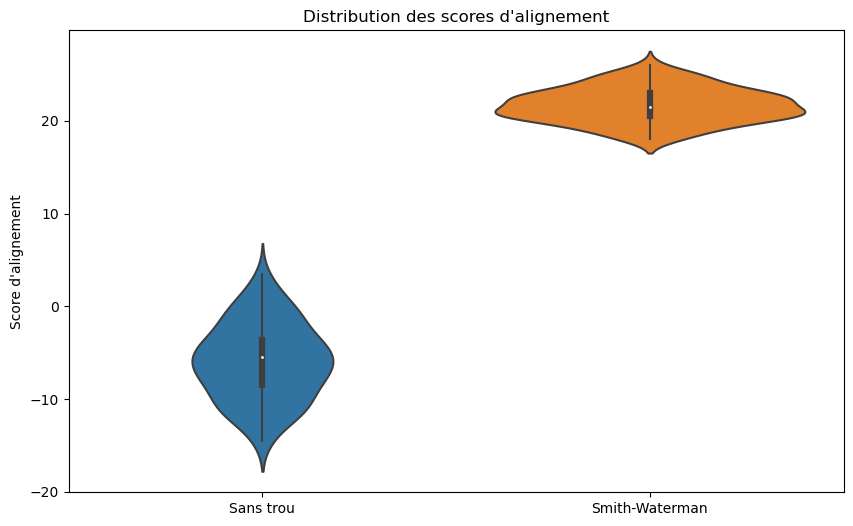

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

def generate_random_sequence(N):
    """Génère une séquence aléatoire de longueur N avec des nucléotides équiprobables."""
    return "".join(random.choices("ATGC", k=N))

def alignment_score_no_gap(x, y, sigma, cmap):
    """Calcule le score d'alignement sans trou entre deux séquences x et y."""
    return sum(sigma[cmap[x[i]], cmap[y[i]]] for i in range(len(x)))

def sw_fwd(x, y, cmap, sigma, gap_params):
    """Construit les matrices de score et de backtracking pour Smith-Waterman."""
    go, ge = gap_params
    S = np.zeros((len(x) + 1, len(y) + 1))
    B = np.zeros((len(x) + 1, len(y) + 1), dtype=int)
    max_score = 0
    max_pos = (0, 0)
    
    for i in range(1, len(x) + 1):
        for j in range(1, len(y) + 1):
            match = S[i-1, j-1] + sigma[cmap[x[i-1]], cmap[y[j-1]]]
            delete = S[i-1, j] - (go if B[i-1, j] == 1 else ge)
            insert = S[i, j-1] - (go if B[i, j-1] == 2 else ge)
            S[i, j], B[i, j] = max((0, 0), (match, 3), (delete, 1), (insert, 2))
            if S[i, j] > max_score:
                max_score = S[i, j]
                max_pos = (i, j)
    
    return S, B, max_score, max_pos

def simulate_alignments(R, N, sigma, cmap, gap_params):
    """Simule R paires de séquences et calcule les scores d'alignement."""
    scores_no_gap = []
    scores_sw = []
    
    for _ in range(R):
        x = generate_random_sequence(N)
        y = generate_random_sequence(N)
        
        score_no_gap = alignment_score_no_gap(x, y, sigma, cmap)
        scores_no_gap.append(score_no_gap)
        
        S, B, max_score, _ = sw_fwd(x, y, cmap, sigma, gap_params)
        scores_sw.append(max_score)
    
    return scores_no_gap, scores_sw

def plot_violin(scores_no_gap, scores_sw):
    """Affiche les distributions des scores sous forme de violin plots."""
    data = [scores_no_gap, scores_sw]
    labels = ["Sans trou", "Smith-Waterman"]
    
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=data)
    plt.xticks(ticks=[0, 1], labels=labels)
    plt.ylabel("Score d'alignement")
    plt.title("Distribution des scores d'alignement")
    plt.show()

# Paramètres
total_sequences = 100  # Nombre de paires (R)
sequence_length = 50  # Taille des séquences (N)
rmap = {"A": 0, "T": 1, "G": 2, "C": 3}
sigma = np.array([[1, -0.5, -0.5, -0.5],
                  [-0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, -0.5],
                  [-0.5, -0.5, -0.5, 1]])
gap_params = (0, 0.5)

# Exécution de la simulation et affichage des résultats
scores_no_gap, scores_sw = simulate_alignments(total_sequences, sequence_length, sigma, rmap, gap_params)
plot_violin(scores_no_gap, scores_sw)


Q3. Qu'observez-vous ?

```markdown
Smith Waterman really help finding a positive score. The difference of score is really big between the no hole sequences and the Smith Waterman ones.
```

Q4. Quelle conclusion peut-on en tirer sur la significativité d'un alignement ?

```markdown
With random sequences, it really helps finding similarities between them. So between close related sequences, it would help as well (especially if they are unalined). That can help as well finding similarities between different species and see if they have a common ancestors or if they have a ancestor-heir relationship. The score can help for the overall sequence, but we can as well take parts of sequence between two species and check their score. That can help find characteristic of two species that is shared among them and see if a part of the sequence is responsable for it. 
```